<a href="https://colab.research.google.com/github/Z5-05/study_third_sem/blob/main/ml/Mephi_ML1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [91]:
# !pip install pyod

In [92]:
import requests
import json
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# https://pyod.readthedocs.io/en/latest/
from pyod.models.ecod import ECOD
from pyod.models.pca import PCA
from pyod.models.knn import KNN

In [93]:
def get_vacancies(max_vacancies, per_page, page_number, job_title):
  dct = {'id': [],
       'name': [],
       'area_name': [],
       'salary_from': [],
       'salary_to': [],
       'salary_gross': [],
       'salary_currency': [],
       'snippet_requirement': [],
       'experience_name': []}
  cnt = 0

  url = 'https://api.hh.ru/vacancies'

  for i in tqdm(range(page_number)):
    par = {'text': job_title,
          'per_page': per_page,
          'page': i,
          'only_with_salary': 'True'}
    r = requests.get(url, params=par)
    vacancies = r.json()
    for vacancy in vacancies['items']:
      if (vacancy['salary']['from'] is None) | (vacancy['salary']['to'] is None):
        continue
      dct['id'].append(vacancy['id'])
      dct['name'].append(vacancy['name'])
      dct['area_name'].append(vacancy['area']['name'])
      dct['salary_from'].append(vacancy['salary']['from'])
      dct['salary_to'].append(vacancy['salary']['to'])
      dct['salary_gross'].append(vacancy['salary']['gross'])
      dct['salary_currency'].append(vacancy['salary']['currency'])
      dct['snippet_requirement'].append(vacancy['snippet']['requirement'])
      dct['experience_name'].append(vacancy['experience']['name'])
      cnt += 1
      if cnt >= max_vacancies:
        return dct
  return dct

In [94]:
max_vacancies = 2000
per_page = 100
page_number = 20
job_title = 'Разработчик'

dct = get_vacancies(max_vacancies, per_page, page_number, job_title)

100%|██████████| 20/20 [00:26<00:00,  1.31s/it]


In [95]:
dataframe = pd.DataFrame.from_dict(dct)
dataframe['clean_sal'] = (dataframe['salary_from'] + dataframe['salary_to']) / 2

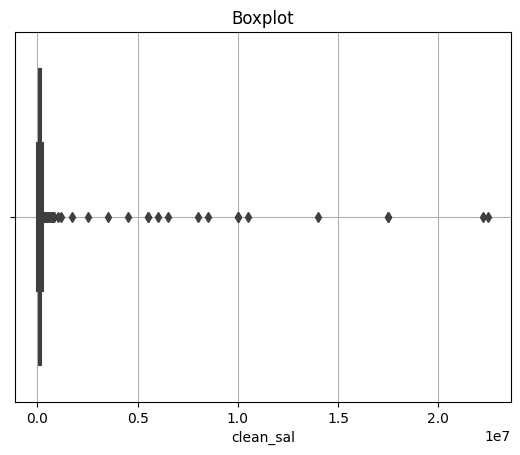

In [96]:
sns.boxplot(x=dataframe["clean_sal"])
plt.title("Boxplot")
plt.grid()
plt.show()

In [97]:
clf1 = ECOD()
clf1.fit(dataframe['clean_sal'].array.reshape(-1, 1))
dataframe['clean_sal_outliers1'] = clf1.decision_scores_

clf2 = PCA()
clf2.fit(dataframe['clean_sal'].array.reshape(-1, 1))
dataframe['clean_sal_outliers2'] = clf2.decision_scores_

clf3 = KNN()
clf3.fit(dataframe['clean_sal'].array.reshape(-1, 1))
dataframe['clean_sal_outliers3'] = clf3.decision_scores_

dataframe['flag'] = (dataframe['clean_sal_outliers1'] != 0).astype(int) + \
                    (dataframe['clean_sal_outliers2'] != 0).astype(int) + \
                    (dataframe['clean_sal_outliers3'] != 0).astype(int)

dataframe1 = dataframe[dataframe['flag'] == 3]

In [98]:
dataframe1[['clean_sal', 'snippet_requirement']].head()

,clean_sal,snippet_requirement
2,32500.0,Высшее или средне-специальное образование (тол...
3,6500000.0,Знание основных технологий frontend разработки...
7,500.0,Умение разрабатывать пользовательский интерфей...
8,600.0,Excellent knowledge of Java. Experience in pro...
15,2050.0,Что нужно знать/уметь/иметь? Опыт коммерческой...
